# Lab 1: Базові алгоритми класифікації з використанням бібліотеки Scikit-learn

Роботу виконав: Пеньковий Тимофій, група ФФ-21мн

Датасет присвячений вимірам з акселерометру і гіроскопу на пристрої під час руху взятий з ресурсу www.kaggle.com . Актуалізація даних проводилась 3.10.2023

# Packages import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score



# Data process

## Import and process data

In [2]:
data_train = pd.read_csv('train_motion_data.csv')
data_test = pd.read_csv('test_motion_data.csv')

In [3]:
is_number = np.vectorize(lambda x: np.issubdtype(x, np.number))
train_mask = is_number(data_train.dtypes)
test_mask = is_number(data_train.dtypes)

print('No gaps' if pd.api.types.is_numeric_dtype(data_train) and pd.api.types.is_numeric_dtype(data_test) else 'Replace some data in column', data_train.columns[~train_mask], data_test.columns[~test_mask])

Replace some data in column Index(['Class'], dtype='object') Index(['Class'], dtype='object')


Replace data that first column will be a Class data

In [4]:
data_train = data_train[['Class'] + [x for x in data_train.columns if x != 'Class']]
data_test = data_test[['Class'] + [x for x in data_test.columns if x != 'Class']]

In [5]:
data_train

,Class,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp
0,NORMAL,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,3581629
1,NORMAL,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,3581630
2,NORMAL,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,3581630
3,NORMAL,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,3581631
4,NORMAL,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,3581631
...,...,...,...,...,...,...,...,...
3639,SLOW,0.915688,-2.017489,1.687505,0.450360,0.384845,-1.236468,3583789
3640,SLOW,-1.934203,0.914925,-0.096013,0.321468,0.649350,-0.477162,3583790
3641,SLOW,-0.222845,0.747304,-0.887430,0.361174,-0.406836,0.054291,3583790
3642,SLOW,-0.349423,0.067261,0.394368,-0.132405,0.020159,-0.004963,3583791


Separate data for their classes

In [6]:
train_normal = data_train.loc[data_train['Class'] == 'NORMAL']
train_slow = data_train.loc[data_train['Class'] == 'SLOW']
train_aggressive = data_train.loc[data_train['Class'] == 'AGGRESSIVE']

test_normal = data_test.loc[data_test['Class'] == 'NORMAL']
test_slow = data_test.loc[data_test['Class'] == 'SLOW']
test_aggressive = data_test.loc[data_test['Class'] == 'AGGRESSIVE']

In [7]:
train_normal

,Class,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp
0,NORMAL,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,3581629
1,NORMAL,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,3581630
2,NORMAL,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,3581630
3,NORMAL,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,3581631
4,NORMAL,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,3581631
...,...,...,...,...,...,...,...,...
1195,NORMAL,-0.820672,2.556599,-0.617599,-0.031612,-0.865596,-0.962189,3582274
1196,NORMAL,-0.016871,1.171574,0.603792,0.253662,0.692110,0.537485,3582275
1197,NORMAL,2.488864,-1.001262,0.432143,0.140041,-0.080023,0.051847,3582275
1198,NORMAL,-0.680338,-0.048300,-3.298533,-0.169057,-0.383012,0.217392,3582276


In [8]:
test_normal

,Class,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp
814,NORMAL,0.697619,0.105949,0.331605,0.083689,0.000840,0.050549,819440
815,NORMAL,1.124378,4.308813,-1.341221,0.006720,0.002673,-0.002596,819440
816,NORMAL,-0.217551,0.020554,0.070902,0.003054,-0.004047,0.004123,819441
817,NORMAL,0.367346,0.377823,0.020036,0.001222,-0.073686,0.011454,819442
818,NORMAL,-0.113025,-0.038479,0.146810,0.001833,0.004505,-0.017868,819442
...,...,...,...,...,...,...,...,...
1806,NORMAL,1.416944,-1.247972,-0.623418,1.490511,0.917138,-0.976315,819976
1807,NORMAL,0.324851,-2.679708,1.041722,0.502742,0.657520,0.315665,819976
1808,NORMAL,1.073423,-2.018279,0.978626,0.117897,-0.869643,0.040164,819977
1809,NORMAL,-0.828570,-2.477492,4.760305,0.131336,0.312381,0.222813,819977


## Print data in fancy figures

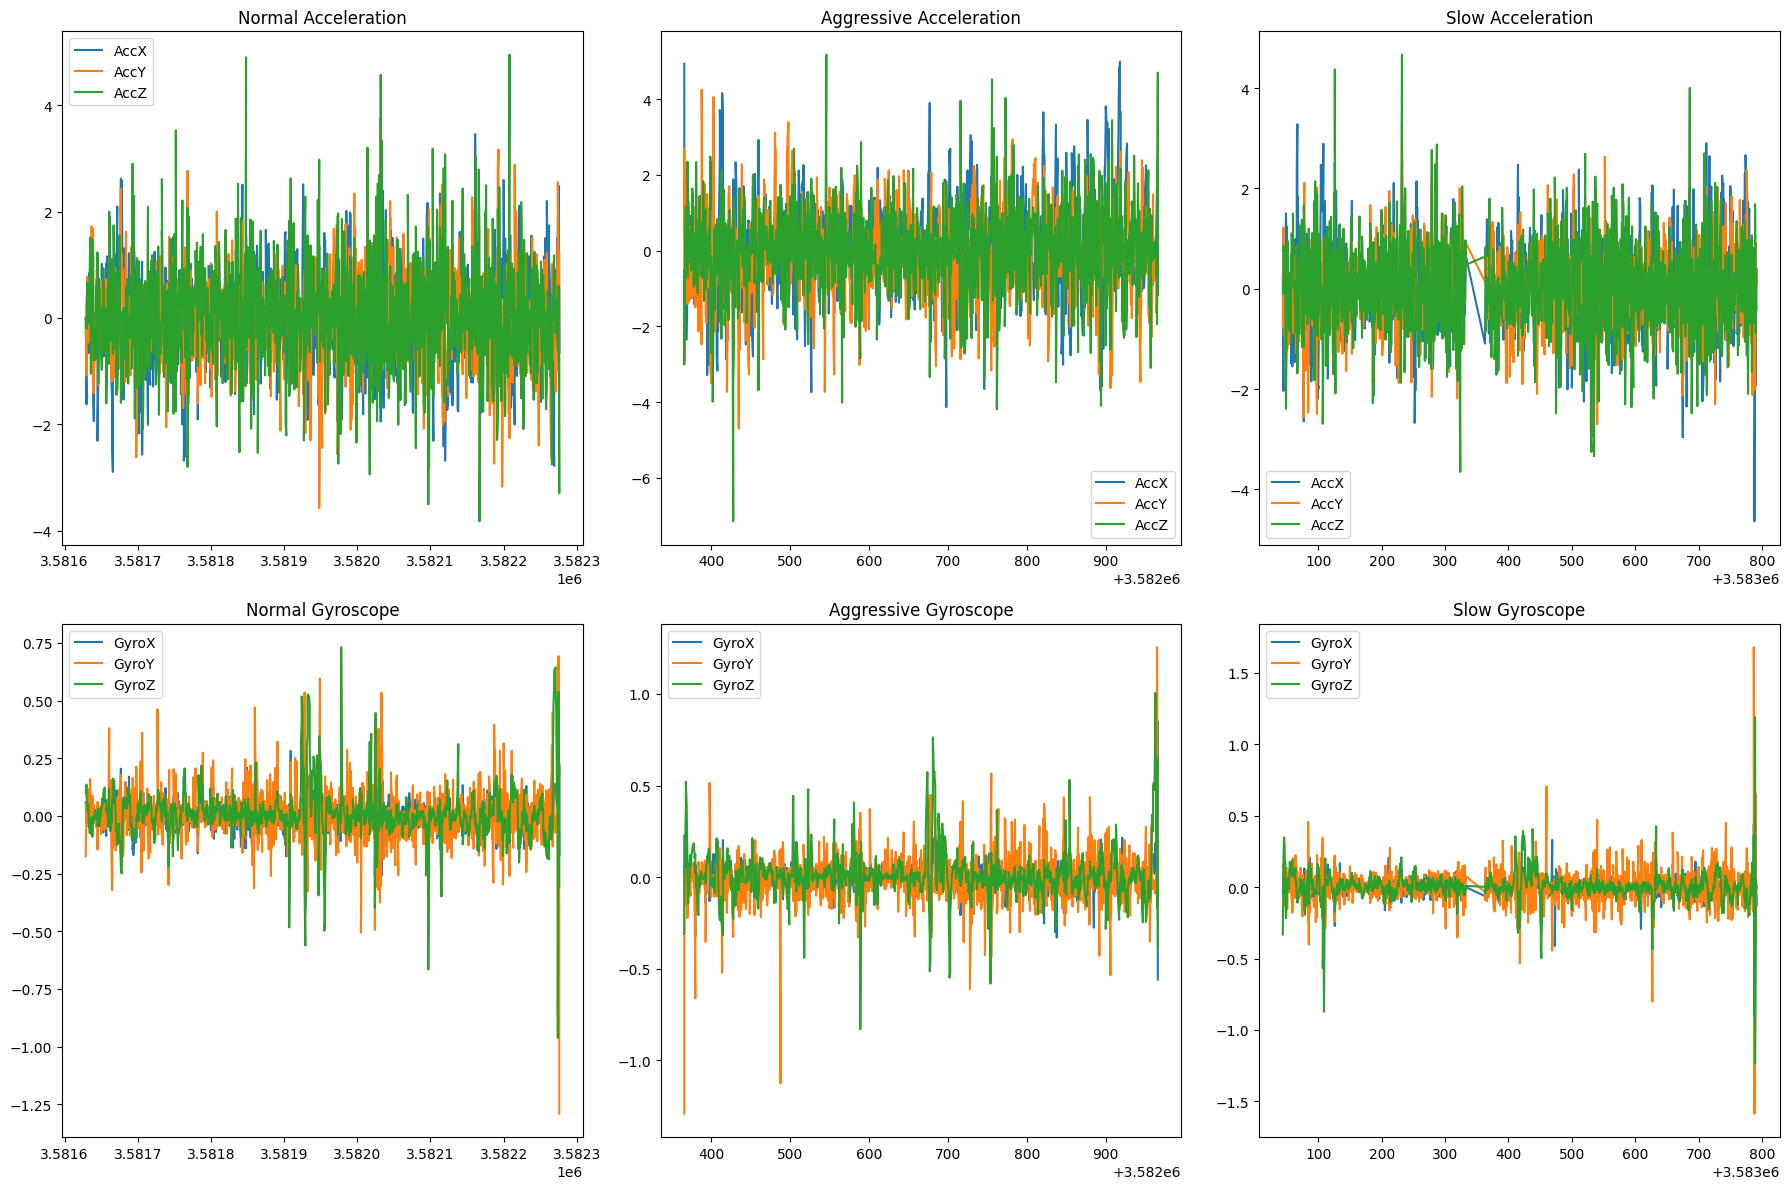

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

classes_train = [train_normal, train_aggressive, train_slow]
graph = ['Acc', 'Gyro']
classes_names = ['Normal', 'Aggressive', 'Slow']
names = ['Acceleration', 'Gyroscope']

for i in range(len(graph)):
    for j, ax in enumerate(axs.flatten()[i*3:3+i*3]):
        ax.plot(classes_train[j]['Timestamp'], classes_train[j][graph[i]+'X'], label= graph[i] + 'X')
        ax.plot(classes_train[j]['Timestamp'], classes_train[j][graph[i]+'Y'], label= graph[i] + 'Y')
        ax.plot(classes_train[j]['Timestamp'], classes_train[j][graph[i]+'Z'], label= graph[i] + 'Z')
        ax.set_title(classes_names[j]+' '+names[i])
        ax.legend()

plt.tight_layout()
plt.show()

Delete some data in swiching mode period

In [10]:
Trash = 10

train_slow = train_slow.iloc[Trash:]
train_slow = train_slow.iloc[:-Trash]

test_slow = test_slow.iloc[Trash:]
test_slow = test_slow.iloc[:-Trash]

train_normal = train_normal.iloc[Trash:]
train_normal = train_normal.iloc[:-Trash]

test_normal = test_normal.iloc[Trash:]
test_normal = test_normal.iloc[:-Trash]

train_aggressive = train_aggressive.iloc[Trash:]
train_aggressive = train_aggressive.iloc[:-Trash]

test_aggressive = test_aggressive.iloc[Trash:]
test_aggressive = test_aggressive.iloc[:-Trash]

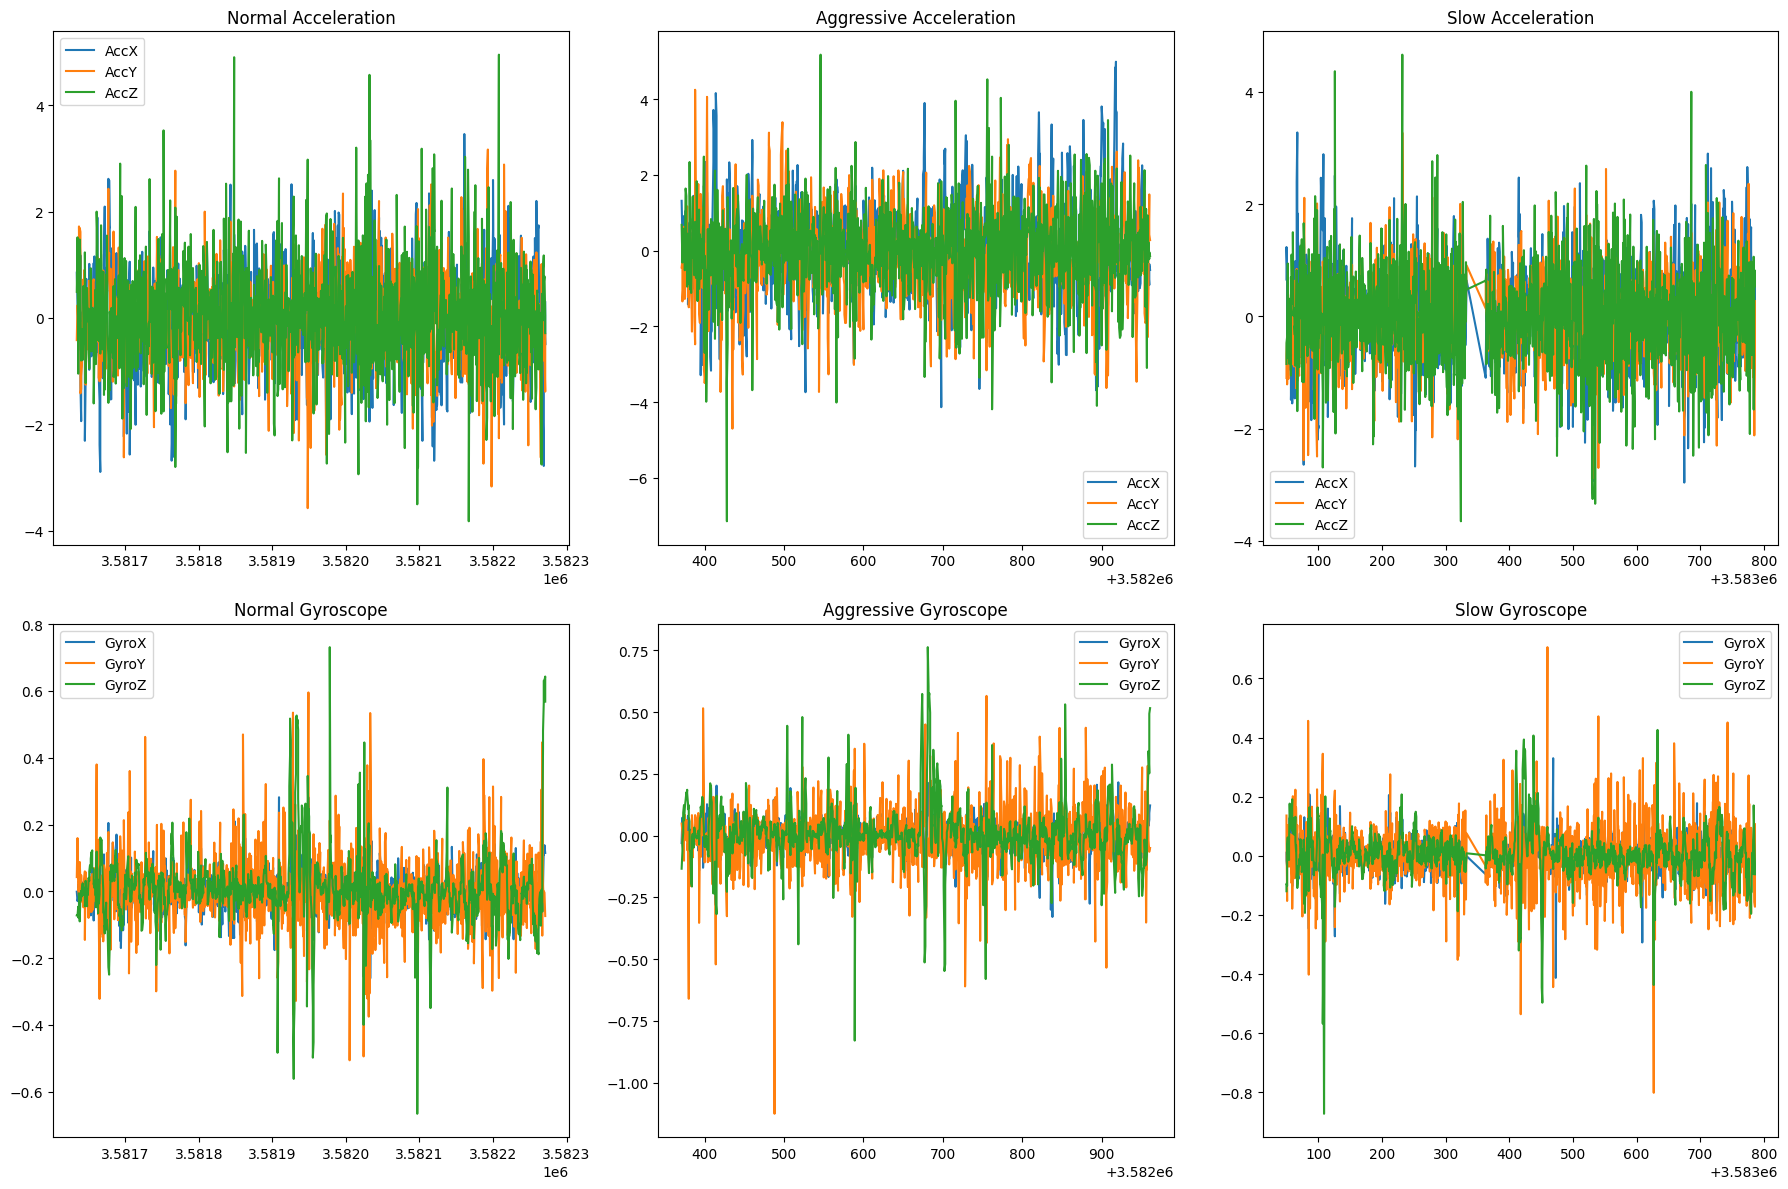

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

classes_train = [train_normal, train_aggressive, train_slow]
graph = ['Acc', 'Gyro']
classes_names = ['Normal', 'Aggressive', 'Slow']
names = ['Acceleration', 'Gyroscope']

for i in range(len(graph)):
    for j, ax in enumerate(axs.flatten()[i*3:3+i*3]):
        ax.plot(classes_train[j]['Timestamp'], classes_train[j][graph[i]+'X'], label= graph[i] + 'X')
        ax.plot(classes_train[j]['Timestamp'], classes_train[j][graph[i]+'Y'], label= graph[i] + 'Y')
        ax.plot(classes_train[j]['Timestamp'], classes_train[j][graph[i]+'Z'], label= graph[i] + 'Z')
        ax.set_title(classes_names[j]+' '+names[i])
        ax.legend()

plt.tight_layout()
plt.show()

In [12]:
data_train.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3.644000e+03
mean,0.040467,-0.073418,0.008271,0.001593,-0.001273,0.007949,3.582707e+06
std,0.985653,0.903408,0.985061,0.066918,0.126205,0.115687,6.421479e+02
min,-4.636523,-4.699795,-7.143998,-0.751822,-1.587028,-1.236468,3.581629e+06
25%,-0.550695,-0.592540,-0.558464,-0.028558,-0.053756,-0.029398,3.582121e+06
50%,0.003931,-0.080833,0.002262,0.001985,-0.001833,0.002978,3.582702e+06
75%,0.595987,0.452401,0.556157,0.031918,0.051313,0.040852,3.583270e+06
max,4.985548,4.245151,5.171739,0.849255,1.679879,1.190500,3.583791e+06


## Heat map for features

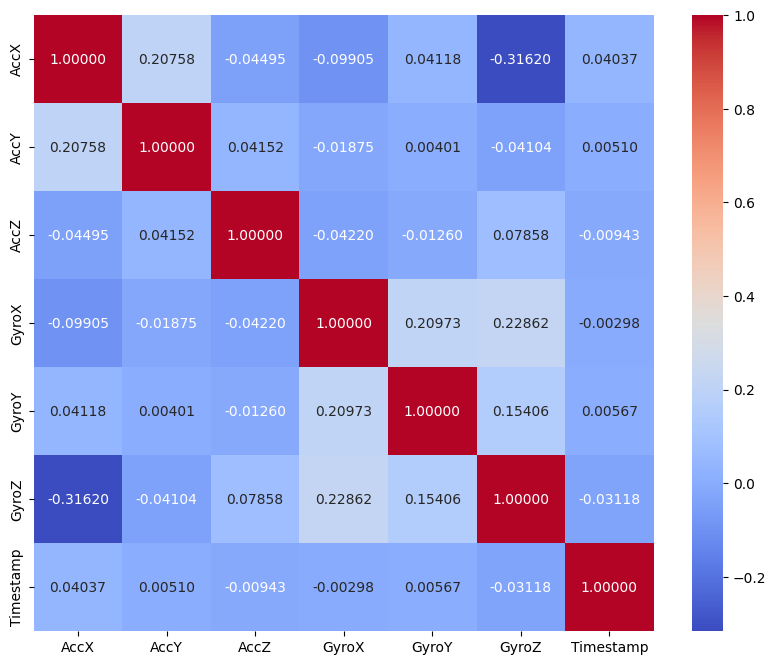

In [13]:
corr = data_train.iloc[:,1:].corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr,  cmap='coolwarm', annot=True, fmt=".5f")
plt.show()

## Separating for traning and test dataset

In [14]:
X_train = data_train.iloc[:, 1:7]
Y_train = data_train.iloc[:, 0]
X_test = data_test.iloc[:, 1:7]
Y_test = data_test.iloc[:, 0]

In [15]:
Y_train

0       NORMAL
1       NORMAL
2       NORMAL
3       NORMAL
4       NORMAL
         ...  
3639      SLOW
3640      SLOW
3641      SLOW
3642      SLOW
3643      SLOW
Name: Class, Length: 3644, dtype: object

In [16]:
labelencoder_X = LabelEncoder()
labelencoder_Y = LabelEncoder()

Y_train = labelencoder_Y.fit_transform(Y_train) 
Y_test = labelencoder_Y.transform(Y_test) 

In [17]:
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_test, Y_test = shuffle(X_test, Y_test, random_state=42)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train) 
scaled_X_test = scaler.transform(X_test) 

In [19]:
Y_train

array([1, 2, 2, ..., 1, 2, 2])

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# KNN model

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)


KNeighborsClassifier()

In [22]:
pred = knn.predict(X_test)

In [23]:
print(confusion_matrix(Y_test,pred))
print(accuracy_score(Y_test,pred))

[[359 236 219]
 [343 343 311]
 [358 477 438]]
0.36964980544747084


Reserch k-value in KNN model 

In [24]:
error_rate = []

n_val = 400

for i in range(1,n_val):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,Y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != Y_test))

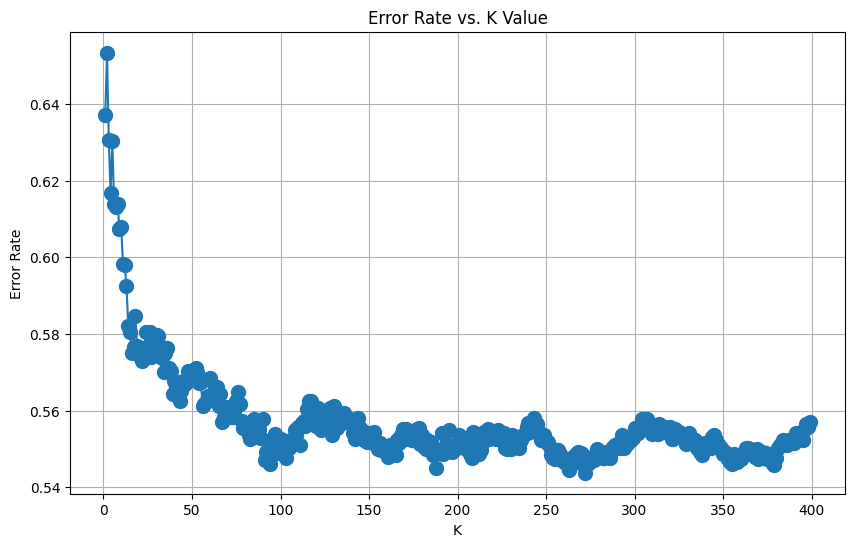

In [25]:
plt.figure(figsize=(10,6))
plt.plot(range(1,n_val), error_rate, marker='o', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid()

In [26]:
print("minimal error:", np.array(error_rate).min())
print("n_neighbors:", np.where(error_rate == np.array(error_rate).min())[0][0])

minimal error: 0.5437743190661478
n_neighbors: 271


# Suport Vector Machines

In [27]:
from sklearn.svm import SVC

SVC_model= SVC(C=1.0, gamma=1, kernel = 'rbf')
SVC_model.fit(X_train,Y_train)

SVC(gamma=1)

In [28]:
pred_SVC = SVC_model.predict(X_test)
print(confusion_matrix(Y_test,pred_SVC))
print(classification_report(Y_test,pred_SVC))
print(accuracy_score(Y_test,pred_SVC))

[[359 167 288]
 [283 250 464]
 [239 355 679]]
              precision    recall  f1-score   support

           0       0.41      0.44      0.42       814
           1       0.32      0.25      0.28       997
           2       0.47      0.53      0.50      1273

    accuracy                           0.42      3084
   macro avg       0.40      0.41      0.40      3084
weighted avg       0.41      0.42      0.41      3084

0.4176394293125811


## Search of best hyper parameters for SVC

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
grid = GridSearchCV(SVC(), param_grid, refit=True)
grid.fit(scaled_X_train,Y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [30]:
grid.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [31]:
grid.best_estimator_

SVC(C=1, gamma=0.1)

In [32]:
pred_SVC_grid = grid.predict(scaled_X_test)
print(confusion_matrix(Y_test,pred_SVC_grid))
print(classification_report(Y_test,pred_SVC_grid))
print(accuracy_score(Y_test,pred_SVC_grid))

[[ 296   69  449]
 [ 199   79  719]
 [ 127   89 1057]]
              precision    recall  f1-score   support

           0       0.48      0.36      0.41       814
           1       0.33      0.08      0.13       997
           2       0.48      0.83      0.60      1273

    accuracy                           0.46      3084
   macro avg       0.43      0.42      0.38      3084
weighted avg       0.43      0.46      0.40      3084

0.46433203631647213


## Decision Tree Classifier

In [33]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model_DTC = DecisionTreeClassifier(criterion='gini')
model_DTC.fit(scaled_X_train, Y_train)
pred_DTC = model_DTC.predict(scaled_X_test)
print(classification_report(Y_test,pred_DTC))
print(accuracy_score(Y_test,pred_DTC))

              precision    recall  f1-score   support

           0       0.31      0.37      0.34       814
           1       0.32      0.33      0.32       997
           2       0.44      0.38      0.41      1273

    accuracy                           0.36      3084
   macro avg       0.36      0.36      0.36      3084
weighted avg       0.37      0.36      0.36      3084

0.35992217898832685


## Random Fores Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

model_RFC = RandomForestClassifier(random_state=666, criterion='gini')
model_RFC.fit(scaled_X_train, Y_train)
pred_RFC = model_RFC.predict(scaled_X_test)
print(classification_report(Y_test,pred_RFC))
print(accuracy_score(Y_test,pred_RFC))

              precision    recall  f1-score   support

           0       0.41      0.40      0.40       814
           1       0.32      0.30      0.31       997
           2       0.46      0.49      0.48      1273

    accuracy                           0.41      3084
   macro avg       0.40      0.40      0.40      3084
weighted avg       0.40      0.41      0.40      3084

0.4062905317769131


## AdaBoost Classifier

In [35]:
from sklearn.ensemble import AdaBoostClassifier

model_ADA = AdaBoostClassifier(n_estimators=100, random_state=666)
model_ADA.fit(scaled_X_train, Y_train)
pred_ADA = model_RFC.predict(scaled_X_test)
print(classification_report(Y_test,pred_ADA))
print(accuracy_score(Y_test,pred_ADA))

              precision    recall  f1-score   support

           0       0.41      0.40      0.40       814
           1       0.32      0.30      0.31       997
           2       0.46      0.49      0.48      1273

    accuracy                           0.41      3084
   macro avg       0.40      0.40      0.40      3084
weighted avg       0.40      0.41      0.40      3084

0.4062905317769131
